In [2]:
#! pip install cache_pandas
#! pip install soccerdata
#! pip install scikit-learn
#! pip install xgboost
#! cd /Users/Gautham/Projects/Betting
#from predict1 import Functions
#from predict import get_league_data
import soccerdata as sd 
import pandas as pd
import os
import numpy as np
from cache_pandas import cache_to_csv
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
import xgboost as xgb

[10/03/23 20:23:17] INFO     No custom team name replacements found. You can configure these in       ]8;id=346337;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=654198;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_config.py#84\84]8;;\
                             /Users/Gautham/soccerdata/config/teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=22437;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=44811;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_config.py#162\162]8;;\
                             /Users/Gautham/soccerdata/config/league_dict.json.                                    

In [421]:
! pip install understatapi

  Using cached understatapi-0.6.1.tar.gz (397 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached urllib3-1.26.5-py2.py3-none-any.whl (138 kB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
  Using cached certifi-2020.12.5-py2.py3-none-any.whl (147 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Created wheel for understatapi: filename=understatapi-0.6.1-py3-none-any.whl size=15008 sha256=23e54c81fe0152993d6e39bc7ad68d44830b9c4fb798382cd784fd0c35847dc5
  Stored in directory: /Users/Gautham/Library/Caches/pip/wheels/f4/97/95/639fcaaed82e063a5cec3610b00f28d866d74e69cb07af593d
Successfully built understatapi
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.12.7
    Uninstalling certifi-2022.12.7:
      Successfully uninstalled certifi-

In [ ]:
import soccerdata as sd 
import pandas as pd
import os
import numpy as np
from cache_pandas import cache_to_csv
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
import xgboost as xgb
import pickle
from datetime import date as d, timedelta
from understatapi import UnderstatClient

class MissingDict(dict):
    __missing__ = lambda self, key: key
    
#path = 'cache/PremierLeague/'
path = 'cache/LaLiga/'
#path = 'cache/SerieA/'
r_time = 600

class Functions:
    def __init__(self, league='PremierLeague', xg=True):
        self.league = league
        self.dic = {'PremierLeague':'ENG-Premier League',
        'LaLiga':'ESP-La Liga',
        'SerieA': 'ITA-Serie A'}
        map_values = {
    'Middlesboro': 'Middlesbrough',
    "Nott'm Forest": 'Forest',
    'Newcastle Utd': 'Newcastle',
    'Luton Town': 'Luton',
    'Manchester City': 'Man City',
    'Manchester Utd': 'Man United',
    'Sheffield Utd': 'Sheffield United',
    "Nott'ham Forest": 'Forest',
    "Nottingham Forest": 'Forest',
    'Manchester United': 'Man United',
    'Wolverhampton Wanderers': 'Wolves',
    'Leicester City': 'Leicester',
    'Newcastle United': 'Newcastle',
    'Queens Park Rangers': 'QPR',
    'West Bromwich Albion': 'West Brom',
    'Vallecano': 'Rayo Vallecano', 
    'Ath Bilbao': 'Bilbao', 
    'Ath Madrid': 'Atletico', 
    'Espanol': 'Espanyol', 
    'Sp Gijon': 'Gijon', 
    'Celta Vigo': 'Celta', 
    'Atlético Madrid': 'Atletico', 
    'Athletic Club': 'Bilbao',
    'Real Sociedad': 'Sociedad',
    'Almería': 'Almeria',
    'Cádiz': 'Cadiz',
    'Alavés': 'Alaves',
    'Hellas Verona': 'Verona',
    'Atletico Madrid': 'Atletico', 
    'Sporting Gijon': 'Gijon',
    'Real Betis': 'Betis',
    'Real Valladolid': 'Valladolid',
    'SD Huesca': 'Huesca'

}
        '''
        'La Coruna', 'Gimnastic', 
        '''
        self.mapping = MissingDict(**map_values)
        self.model = None
        self.filename = f'models/{self.league}_model.sav'
        self.xg = xg

    @cache_to_csv(path + 'league.csv', refresh_time=r_time)
    def get_league_data(self):
        directory = f'/Users/Gautham/Projects/Betting/Data/{self.league}'
        total_df = pd.DataFrame()
        # iterate over files in
        # that directory
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            # checking if it is a file
            if os.path.isfile(f) and filename[-3:] == 'csv':
                print(f)
                df = pd.read_csv(f, encoding='unicode_escape')
                total_df = pd.concat([total_df,df], join='outer')
        return total_df

    @cache_to_csv(path + 'schedule.csv', refresh_time=r_time)
    def get_schedule(self):
        
        fbref = sd.FBref(self.dic[self.league], '2023')
        sched23 = fbref.read_schedule()

        sched23 = sched23.droplevel('league')
        sched23 = sched23.droplevel('season')

        sched23 = sched23.rename(columns={'date':'Date', 'home_team':'HomeTeam', 'away_team':'AwayTeam', 'referee': 'Referee'})
        sched23['Date'] = pd.to_datetime(sched23['Date'], yearfirst=True).dt.strftime('%Y-%m-%d')
        sched23[['BbAv>2.5', 'BbAv<2.5', 'BbAvH', 'BbAvD', 'BbAvA']] = None
        sched23 = sched23.reset_index(drop=True)
        return sched23
    
    @cache_to_csv(path + "current_season.csv", refresh_time=r_time)
    def get_current_season(self):
        df = pd.DataFrame()
        #years =  ['0102', '0203','0304','0405','0506','0607','0708','0809','0910','1011','1112','1213','1314','1415','1516','1617','1718','1819','1920','2021','2122','2223','2323']
        years = ['2324']

        for year in years: 
            history = sd.MatchHistory(self.dic[self.league], year)
            sched = history.read_games()
            df = pd.concat([df, sched])


        sched23 = df

        sched23 = sched23.droplevel('league')
        sched23 = sched23.droplevel('season')

        sched23 = sched23.rename(columns={'date':'Date', 'home_team':'HomeTeam', 'away_team':'AwayTeam', 'referee': 'Referee'})
        sched23['Date'] = pd.to_datetime(sched23['Date'], yearfirst=True).dt.strftime('%d-%m-%y')
        
        #sched23[['BbAv>2.5', 'BbAv<2.5', 'BbAvH', 'BbAvD', 'BbAvA']] = None
        sched23['HomeTeam'] = sched23['HomeTeam'].map(self.mapping)
        sched23['AwayTeam'] = sched23['AwayTeam'].map(self.mapping)
        sched23 = sched23.reset_index(drop=True)
        return sched23
        
    @cache_to_csv(path + "elo.csv", refresh_time=r_time)
    def get_elo_data(self,full_df):
        clubelo = sd.ClubElo(self.dic[self.league])
        missing = []
        # create elo df
        elo_df = pd.DataFrame()
        #print(full_df['Team'].unique())
        for club in full_df['Team'].unique():
            print('hi', club)
            try:
                elo = clubelo.read_team_history(club)
                elo_df = pd.concat([elo_df,elo])
            except:
                missing.append(club)
            #print(elo_df)
        print(missing)
        elo_df = elo_df.reset_index()
        elo_df = elo_df[elo_df['from'] > '2000'] 
        #print(elo_df)

        # add nottingham data
        '''
        elo_df = pd.concat([elo_df, clubelo.read_team_history('Forest')])
        elo_df['team'].replace(['Forest'], "Nott'm Forest", regex=True, inplace=True)
        elo_df = elo_df.reset_index()
        '''
        # merge elo with full df
        out = full_df.merge(elo_df[['team', 'elo', 'from', 'to']], how='left', left_on=['Team'], right_on=['team']) 
        out = out.query('Date.between(`from`, `to`)')
        out = out.merge(elo_df[['team', 'elo', 'from', 'to']], how='left', left_on=['Opponent'], right_on=['team']) 
        out = out.query('Date.between(`from_y`, `to_y`)')
        out = out.reset_index(drop=True)
        out['ELODif'] = out['elo_x'] - out['elo_y']
        out = out.rename(columns={'elo_x':'TeamELO', 'elo_y':'OpponentELO'})
        out = out.drop(columns=['from_x', 'from_y', 'to_x', 'to_y', 'team_x', 'team_y'])
        return out

    @cache_to_csv(path + "understat.csv", refresh_time=160000)
    def get_understat(self):
        league_dic = {'PremierLeague': 'EPL',
        'LaLiga': 'La_Liga',
        'SerieA': 'Serie_A'}
        understat = UnderstatClient()
        years = range(2014,2024)
        teams = set()
        for year in years:
            t = understat.league(league_dic[league]).get_team_data(str(year))
            df = pd.DataFrame(t)
            ts = df.reset_index().iloc[1].unique()[1:]
            y = set(ts)
            teams.update(y)
        #print(teams)
        understat = UnderstatClient()
        df = pd.DataFrame()
        missing = {}
        #print(teams)
        for team in teams:
            t = understat.team(team=team)
            print(team)
            for year in years:
                print(year)
                try:
                    y = pd.json_normalize(t.get_match_data(str(year)))
                    df = pd.concat([df, y])
                except:
                    missing[year] = missing.get(year, []) + [team]
        print(f'missing understat teams: {missing}')
        return df

    @cache_to_csv(path + "xG.csv", refresh_time=r_time)
    def get_xg(self):  
        df1 = self.get_understat()
        df1 = df1.sort_values('datetime')
        df1 = df1.rename(columns={'h.title':'HomeTeam',                   'a.title':'AwayTeam', 'datetime': 'Date',
        'xG.h': 'HomeTeamxG', 'xG.a': 'AwayTeamxG',
        'result': 'Result'})

        df1['Date'] = pd.to_datetime(df1['Date']).dt.strftime('%Y-%m-%d')

        df1['Result'] = df1['Result'].str.upper()
        df1 = df1.drop_duplicates(['id'])#['Date', 'HomeTeam', 'AwayTeam'])
        df1 = self.home_away(df1)
        #df1.to_csv(f'cache/{self.league}/xG.csv')
        
        return df1

    def rename_cols(self, df):
        c1 = df.filter(like='HomeTeam').columns

        c2 = c1.str.replace('HomeTeam', 'Team')
        df = df.rename(columns={**dict(zip(c1, c2)), **dict(zip(c2, c1))})
        c1 = df.filter(like='AwayTeam').columns

        c2 = c1.str.replace('AwayTeam', 'Opponent')

        df = df.rename(columns={**dict(zip(c1, c2)), **dict(zip(c2, c1))})
        df['Team'] = df['Team'].map(self.mapping)
        df['Opponent'] = df['Opponent'].map(self.mapping)

        df['Venue'] = 'Home'
        return df

    def home_away(self,df):
        if 'Team' not in df.columns:
            df = self.rename_cols(df)
        if 'GameID' not in df.columns:
            df['GameID'] = range(df.shape[0])

        c1 = df.filter(like='Team').columns
        c2 = c1.str.replace('Team', 'Opponent')
        
        swap = df.rename(columns={**dict(zip(c1, c2)), **dict(zip(c2, c1))})
        swap['Venue'] = 'Away'
        df['Result'] = np.where(df['Result'] == 'H', 'W', np.where(df['Result'] == 'A', 'L', df['Result']))
        swap['Result'] = np.where(swap['Result'] == 'H', 'L', np.where(swap['Result'] == 'A', 'W', swap['Result']))
        #swap['Result'] = np.where(swap['Result'] == 'H', 'A', np.where(swap['Result'] == 'A', 'H', 'D'))
        #print(swap)
        df = pd.concat([df,swap])
        
        #df['Result'] = np.where(df['Result'] != 'W', 'L', df['Result'])
        #df = df.rename(columns={'Team1':'Team', 'Team2':'Opponent'})
        df = df.sort_values(by='GameID').reset_index(drop=True)
        return df

    def preprocess(self, total_df):    
        try:
            total_df['Date'] = pd.to_datetime(total_df['Date'], dayfirst=True, format='mixed')
        except:
            total_df['Date'] = pd.to_datetime(total_df['Date'], dayfirst=True, format='mixed')
        
        total_df = total_df.sort_values(by='Date')
        total_df['GameID'] = range(len(total_df))

        df = total_df
        #return df
        #return df.filter(like='>2.5')#.isna().sum()
        df = total_df[['GameID', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'BbAv>2.5', 'BbAv<2.5', 'AvgC>2.5', 'AvgC<2.5', 'B365H', 'B365D', 'B365A', 'AvgCH', 'AvgCD', 'AvgCA', 'B365>2.5', 'B365<2.5']]
        
        #df['O2.5'] = np.where(df['AvgC>2.5'].isna(),np.where(~df['BbAv>2.5'].isna(),df['BbAv>2.5'],df['B365>2.5']),df['AvgC>2.5'])
        #df['O2.5'] = df['B365>2.5']
        #df['U2.5'] = df['B365<2.5']
        df['O2.5'] = np.where(df['BbAv>2.5'].isna(),df['B365>2.5'],df['BbAv>2.5'])
        df['U2.5'] = np.where(df['AvgC<2.5'].isna(),np.where(~df['BbAv<2.5'].isna(),df['BbAv<2.5'],df['B365<2.5']),df['AvgC<2.5'])
        #df['U2.5'] = np.where(df['BbAv<2.5'].isna(),df['B365<2.5'],df['BbAv<2.5'])

        #['O2.5'].isna().sum())
        
        df['HomeTeamWinOdds'] = df['B365H']#np.where(df['AvgCH'].isna(),df['BbAvH'],df['AvgCH'])
        df['AwayTeamWinOdds'] = df['B365A']#np.where(df['AvgCA'].isna(),df['BbAvA'],df['AvgCA'])
        df['DrawOdds'] = df['B365D']#np.where(df['AvgCD'].isna(),df['BbAvD'],df['AvgCD'])
        
        df.columns = ['GameID', 'Date', 'HomeTeam', 'AwayTeam', 'HomeTeamGoals', 'AwayTeamGoals', 'Result', 'HomeTeamShots', 'AwayTeamShots', 'HomeTeamShotsonTarget', 'AwayTeamShotsonTarget', 'HomeTeamFouls', 'AwayTeamFouls', 'HomeTeamCorners', 'AwayTeamCorners', 'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards', 'AwayTeamRedCards', 'BbO2.5', 'BbU2.5', 'AvgO2.5', 'AvgU2.5','BbHome', 'BbDraw', 'BbAway', 'AvgH', 'AvgD', 'AvgA', 'B365O', 'B365U', 'O2.5', 'U2.5', 'HomeTeamWinOdds',  'AwayTeamWinOdds', 'DrawOdds']

        df = df[['GameID', 'Date', 'HomeTeam', 'AwayTeam', 'HomeTeamGoals', 'AwayTeamGoals', 'Result', 'HomeTeamShots', 'AwayTeamShots', 'HomeTeamShotsonTarget', 'AwayTeamShotsonTarget', 'HomeTeamFouls', 'AwayTeamFouls', 'HomeTeamCorners', 'AwayTeamCorners', 'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards', 'AwayTeamRedCards', 'O2.5', 'U2.5', 'HomeTeamWinOdds', 'DrawOdds', 'AwayTeamWinOdds']]
        df = df.sort_values(by='Date')

        df = self.home_away(df)
        return df

    def create_predictors(self,df):
        print(df.columns)
        df['VenueCode'] = df['Venue'].astype('category').cat.codes
        df['OpponentCode'] = df['Opponent'].astype('category').cat.codes
        df['DayCode'] = pd.to_datetime(df['Date']).dt.dayofweek
        df['OU1.5Target'] = (df['TotalGoals'] > 1.5).astype('int')
        df['OU2.5Target'] = (df['TotalGoals'] > 2.5).astype('int')
        df['OU3.5Target'] = (df['TotalGoals'] > 3.5).astype('int')
        df['WinLoseTarget'] = df['Result'].astype('category').cat.codes #(new['Result'] == 'W').astype('int')
        df['WinTarget'] = (df['Result'] == 'W').astype('int')#new['Result'].astype('category').cat.codes
        df['DrawTarget'] = (df['Result'] == 'D').astype('int')
        df['LossTarget'] = (df['Result'] == 'L').astype('int')
        df['OUCornersTarget'] = (df['TotalCorners'] > 9.5).astype('int')
        return df.reset_index(drop=True)

    def rolling_averages(self,group, cols, new_cols):
        group = group.sort_values(by='Date')
        rolling_stats = group[cols].rolling(3, min_periods=2, closed='left').mean()
        group[new_cols] = rolling_stats
        group = group.dropna(subset=new_cols)
        return group
    
    def create_rolling(self,merged_df, cols):
        
        new_cols = [f'{c}Rolling' for c in cols]
        df_rolling = merged_df.groupby('Team').apply(lambda x: self.rolling_averages(x, cols, new_cols))

        df_rolling = df_rolling.droplevel('Team')
        df_rolling = df_rolling.sort_values('GameID')
        df_rolling.index = range(df_rolling.shape[0])
        return df_rolling, new_cols

    def calculate_difs(self, df, cols, rolling=True):
        if rolling:
            new_cols = [f'{c}Rolling_Dif' for c in cols]
            for i,c in enumerate(cols):
                df[new_cols[i]] = df[f'Team{c}Rolling'] - df[f'Opponent{c}Rolling']
        else:
            new_cols = [f'{c}Dif' for c in cols]
            for i,c in enumerate(cols):
                df[new_cols[i]] = df[f'Team{c}'] - df[f'Opponent{c}']
        return df, new_cols

    def add_xg(self, df):
        print('heyyyyyyyyyy')
        xG = self.get_xg()#pd.read_csv(f'cache/{self.league}/xG.csv')
        '''
        print teams with different names
        '''
        li1 = xG['Team'].unique()
        s = set(df['Team'].unique())
        print('teams with different names:', [x for x in li1 if x not in s])

        df['Date'] = pd.to_datetime(df['Date'])
        xG['Date'] = pd.to_datetime(xG['Date'])
        df = df.merge(xG[['Date', 'Team', 'TeamxG', 'OpponentxG']], on=['Date', 'Team'])
        return df
    
    def calculate_totals(self, df, cols):
        new_cols = [f'Total{col}' for col in cols]
        for i, new_col in enumerate(new_cols):
            df[new_col] = df[f'Team{cols[i]}'] + df[f'Opponent{cols[i]}']
        
        return df, new_cols
    
    def create_stats(self, df):
        if self.xg:
            total_cols = ['Goals', 'xG', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards', 'ELO']
            total_cols1 = ['Goals', 'xG', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards']
            ind_cols = ['TeamGoals', 'OpponentGoals', 'TeamxG', 'OpponentxG', 'TeamShots', 'OpponentShots', 'TeamFouls', 'OpponentFouls','TeamShotsonTarget', 'OpponentShotsonTarget', 'TeamCorners', 'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards','TeamRedCards','OpponentRedCards']

        else:
            total_cols = ['Goals', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards', 'ELO']
            total_cols1 = ['Goals', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards']
            ind_cols = ['TeamGoals', 'OpponentGoals', 'TeamShots', 'OpponentShots', 'TeamFouls', 'OpponentFouls','TeamShotsonTarget', 'OpponentShotsonTarget', 'TeamCorners', 'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards','TeamRedCards','OpponentRedCards']
        pred_cols = []
        
        df = self.get_elo_data(df)
        if self.xg:
            df = self.add_xg(df)
        df, new_cols = self.calculate_totals(df, total_cols)
        df, new_cols = self.create_rolling(df, new_cols)
        pred_cols.extend(new_cols)
        df, new_cols = self.create_rolling(df, ind_cols)
        pred_cols.extend(new_cols)
        print(new_cols)
        df, dif_cols = self.calculate_difs(df, total_cols1, rolling=True)
        print(dif_cols)
        pred_cols.extend(dif_cols)
        return df, pred_cols
    
    def random_forest_win(self,data, predictors, train, test, call_type, target_col, model_type):  
        if model_type == 'RF':
            model = RandomForestClassifier(n_estimators=50, min_samples_split=7, random_state=1) 
        else: 
            params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 0, 'subsample': 0.8}
            model = xgb.XGBClassifier(**params)#, objective='binary:logistic')

        #model = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.8, min_samples_leaf=17, min_samples_split=5, n_estimators=100)
        '''
        param_grid = {
            "max_depth": [3],
            "learning_rate": [0.01],
            "gamma": [0, 0.25, 1],
            "reg_lambda": [0, 1, 10],
            "scale_pos_weight": [1, 3, 5],
            "subsample": [0.8],
            "colsample_bytree": [0.5],
        }
        '''
        param_grid = {
            "max_depth": [3],
            "learning_rate": [0.01],
            "gamma": [0, 0.25, 1],
            "reg_lambda": [0, 1, 10],
            "subsample": [0.8],
            "colsample_bytree": [0.5],
        }

        params = {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.8}
        params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 0, 'subsample': 0.8}
        #params = {'colsample_bytree': 0.5, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 3, 'reg_lambda': 10, 'subsample': 0.8}
        
        #model = xgb.XGBClassifier(**params)#, objective='binary:logistic')
        #model = xgb.XGBRegressor()
        #grid_cv = GridSearchCV(model, param_grid, n_jobs=-1, cv=3, scoring='roc_auc')
        #_ = grid_cv.fit(train[predictors], train[target_col])
        #print(grid_cv.best_score_, grid_cv.best_params_)

        #model.fit(train[predictors], train['Target'])
        model.fit(train[predictors], train[target_col])
        preds = model.predict(test[predictors])
        #return preds,1,1
        #if call_type == 'predict':
        #    return preds, model
        #combined = pd.DataFrame(dict(actual=test['Target'], prediction=preds), index = test.index)
        #print(test.groupby('GameID').filter(lambda x: x['prediction'].sum()==1))
        precision = precision_score(test[target_col], preds, average='micro')
        accuracy = accuracy_score(test[target_col], preds)
        combined = pd.DataFrame(dict(actual=test[target_col], prediction=preds), index = test.index)
        c1 = combined.merge(data[['Date', 'Team', 'Opponent', 'TeamGoals', 'OpponentGoals','GameID', 'Venue']], left_index=True, right_index=True)

        # predictions where both home and away team prediction match
        predictions = c1.groupby('GameID').filter(lambda x: x['prediction'].sum()==1)
        #print(predictions)
        table = c1[['GameID','Date','Team', 'Opponent', 'prediction', 'actual']].merge(c1[['GameID','Date','Team', 'Opponent', 'prediction']], left_on=['Date', 'Team'], right_on=['Date', 'Opponent']).drop_duplicates(['GameID_x'])

        table = table[table['prediction_x'] == table['prediction_y']]#.filter(lambda x: x['prediction_x'] != x['prediction_y'])
        precision1 = precision_score(table['actual'], table['prediction_x'], average='micro')
        accuracy1 = accuracy_score(table['actual'], table['prediction_x'])
        values_to_write = [f'League-{self.league}',
            f'Target-{target_col}', f'Precision1-{precision1}', 
            f'Accuracy1- {accuracy1}', f'Precision-{precision}', 
            f'Accuracy-{accuracy}']
        with open('models/model_stats.txt', 'w') as f:
            for line in values_to_write:
                f.write(line)
                f.write('\n')
        
        #precision, accuracy = 1,1
        #precision = cross_val_score(model, train[predictors], train['TotalGoals'], scoring='neg_mean_absolute_error')
        return table, precision1, accuracy1, model, combined

    def prep_data(self, rolling, date):
        if self.xg:
            total_cols = ['Goals', 'xG', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards', 'ELO']
            total_cols1 = ['Goals', 'xG', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards']
            ind_cols = ['TeamGoals', 'OpponentGoals', 'TeamxG', 'OpponentxG', 'TeamShots', 'OpponentShots', 'TeamFouls', 'OpponentFouls','TeamShotsonTarget', 'OpponentShotsonTarget', 'TeamCorners', 'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards','TeamRedCards','OpponentRedCards']

        else:
            total_cols = ['Goals', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards', 'ELO']
            total_cols1 = ['Goals', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards']
            ind_cols = ['TeamGoals', 'OpponentGoals', 'TeamShots', 'OpponentShots', 'TeamFouls', 'OpponentFouls','TeamShotsonTarget', 'OpponentShotsonTarget', 'TeamCorners', 'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards','TeamRedCards','OpponentRedCards']
        #rolling = pd.read_csv(f'cache/LaLiga/rolling.csv')
        elo = pd.read_csv(f'cache/{self.league}/elo.csv')
        schedule = self.get_schedule()#pd.read_csv(f'cache/{self.league}/schedule.csv')
        #print(rolling['Date'])
        recent_rolling = rolling.groupby(['Team']).last().reset_index()
        #schedule.loc[(schedule['Date'] == '23/09/23') | (schedule['Date'] == '24/09/23')]
        #print(recent_rolling.Team)
        #for date in dates:
        #print(schedule.Date)
        
        sched = schedule.loc[schedule['Date'] >= date]#(schedule['Date'] == date)]])
        #print(schedule['Date'], sched['Date'],date)
        #print(sched.shape, 'hi')
        sched['Result'] = -1
        sched = self.rename_cols(sched)
        #print(recent_rolling)
        #print(sched.shape, 'hi', recent_rolling.columns, sched.columns)
        #xG = pd.read_csv(f'cache/{league}/xG.csv')

        
        #sched = self.add_xg(sched)
        #print(sched.columns, 'columns')
        sched['Date'] = pd.to_datetime(sched['Date'])
        sched = sched.merge(recent_rolling[['Team', 'TeamELO']], on='Team', how='inner')
        #print(sched.head(10)[['Date','Team', 'Opponent']].sort_values('Date'))
        #print(sched.columns, 'columns')
        #print(sched.shape)
        sched = sched.merge(recent_rolling[['Opponent', 'OpponentELO']], on='Opponent', how='inner')
        print(sched.columns)
        
        #return sched.merge(xG[['Date', 'Team', 'TeamxG', 'OpponentxG']], on=['Date', 'Team'])
        
        sched = sched.sort_values('Date').drop_duplicates(['Date', 'Team'])
        #print(sched.head(10)[['Date','Team', 'Opponent']])
        if self.xg:
            sched = self.add_xg(sched)
        print(sched.columns)
        print(sched.head(10))
        sched = self.home_away(sched)
        

        sched, _ = self.calculate_totals(sched, ['ELO'])
        sched, _ = self.calculate_difs(sched, ['ELO'], rolling=False)
        
        sched = sched.sort_values('Date')
        #sched, _ = self.create_rolling(sched, ['TotalELO'])
        #return sched
        
        #return sched
        #print(sched, 'team')
        #print(sched,' hey')
        #sched['ELODif'] = sched['TeamELO'] - sched['OpponentELO']
        #sched, cols = self.create_stats(sched)
        #return sched
        
        #sched['Date'] = pd.to_datetime(sched['Date'], dayfirst=True).dt.date
        #print(sched['Team'], 'team')
        #print(sched.shape)#['Date'], 'hi')
        cols = ['Date', 'Team', 'Opponent', 'TeamELO', 'OpponentELO', 'ELODif', 'Venue', "GameID"]
        #return sched[sched.columns.intersection(elo.columns)]
        new = pd.concat([rolling, sched[sched.columns.intersection(rolling.columns)]], axis=0).reset_index(drop=True)
        #return new
        #['Date'].unique(),'hi')
        #new['TotalGoals'] = new['TeamGoals'] + new['OpponentGoals']
        new['Date'] = pd.to_datetime(new['Date'], dayfirst=True).dt.date
        #total_cols = ['Goals', 'xG', 'Shots', 'Fouls', 'ShotsonTarget', 'Corners', 'YellowCards', 'RedCards', 'ELO']
        #new[new['Date'] > date]['ELO']
        #new = self.calculate_totals(new)
        #return new
        #new = self.create_predictors(new)
        new, new_cols = self.calculate_totals(new, total_cols)
        new, new_cols = self.create_rolling(new, new_cols)
        new, new_cols = self.create_rolling(new, ind_cols)
        new, dif_cols = self.calculate_difs(new, total_cols1)
        new = self.create_predictors(new)

        #numeric_cols = ['Shots', 'ShotsonTarget', 'Fouls', 'Corners', 'YellowCards', 'RedCards']
        #cols = ['Goals','Shots', 'ShotsonTarget', 'Corners']
        #dif_cols = 
        #print(new.columns, 'h')
        #new, dif_cols = self.calculate_difs(new, cols)
        #new['WinLoseTarget'] = new['Result'].astype('category').cat.codes #(new['Result'] == 'W').astype('int')
        #new['WinTarget'] = (new['Result'] == 'W')#new['Result'].astype('category').cat.codes
        #new['DrawTarget'] = (new['Result'] == 'D')
        #new['LossTarget'] = (new['Result'] == 'L')
        #print(new['Date'])
        new.to_csv(f'cache/{self.league}/new.csv')
        '''
        #rolling = pd.read_csv(f'cache/LaLiga/rolling.csv')
        elo = pd.read_csv(f'cache/{self.league}/elo.csv')
        schedule = self.get_schedule()#pd.read_csv(f'cache/{self.league}/schedule.csv')
        #print(rolling['Date'])
        recent_rolling = rolling.groupby(['Team']).last().reset_index()
        #schedule.loc[(schedule['Date'] == '23/09/23') | (schedule['Date'] == '24/09/23')]
        #print(recent_rolling.Team)
        #for date in dates:
        #print(schedule.Date)
        
        sched = schedule.loc[schedule['Date'] >= date]#(schedule['Date'] == date)]])
        print(schedule['Date'], sched['Date'],date)
        #print(sched.shape, 'hi')
        sched['Result'] = -1
        sched = self.rename_cols(sched)
        #print(recent_rolling)
        #print(sched.shape, 'hi', recent_rolling.columns, sched.columns)
        #xG = pd.read_csv(f'cache/{league}/xG.csv')
        if self.xg:
            sched = self.add_xg(sched)#sched.merge(xG[['Date', 'Team', 'TeamxG', 'OpponentxG']], on=['Date', 'Team'])
        sched = sched.merge(recent_rolling[['Team', 'TeamELO']], on='Team', how='inner')
        #print(sched.shape)
        sched = sched.merge(recent_rolling[['Opponent', 'OpponentELO']], on='Opponent', how='inner')
        sched = sched.sort_values('Date').drop_duplicates(['Date', 'Team'])
        sched = self.home_away(sched)
        #print(sched, 'team')
        print(sched,' hey')
        sched['ELODif'] = sched['TeamELO'] - sched['OpponentELO']
        #sched['Date'] = pd.to_datetime(sched['Date'], dayfirst=True).dt.date
        #print(sched['Team'], 'team')
        #print(sched.shape)#['Date'], 'hi')
        new = pd.concat([elo, sched[['Date', 'Team', 'Opponent', 'TeamELO', 'OpponentELO', 'ELODif', 'Venue', "GameID"]]])
        print(new)#['Date'].unique(),'hi')
        #return new

        new['Date'] = pd.to_datetime(new['Date'], dayfirst=True).dt.date
        
        new = self.create_predictors(new)
        new = self.create_rolling(new)
        print(new['Date'],date)
        numeric_cols = ['Shots', 'ShotsonTarget', 'Fouls', 'Corners', 'YellowCards', 'RedCards']
        cols = ['Goals','Shots', 'ShotsonTarget', 'Corners']
        #print(new.columns, 'h')
        new, dif_cols = self.calculate_difs(new, cols)
        #new['WinLoseTarget'] = new['Result'].astype('category').cat.codes #(new['Result'] == 'W').astype('int')
        #new['WinTarget'] = (new['Result'] == 'W')#new['Result'].astype('category').cat.codes
        #new['DrawTarget'] = (new['Result'] == 'D')
        #new['LossTarget'] = (new['Result'] == 'L')
        #print(new['Date'])
        new.to_csv(f'cache/{self.league}/new.csv')
        return dif_cols
        '''

In [156]:
league = 'LaLiga'
func = Functions(league, xg=True)
print('getting league')
prem_df = func.get_league_data()
print('getting schedule')
sched23 = func.get_current_season()
new_df2023 = pd.concat([prem_df, sched23])


print('preprocess')
df1 = func.preprocess(new_df2023)

df, rolling_cols = func.create_stats(df1)
df_rolling = func.create_predictors(df)
date = str(d.today())
#df_rolling = pd.read_csv(f'cache/{league}/rolling.csv')
s = func.prep_data(df_rolling, date)
s#[s['Date'] == '2023-09-29'].filter(like='ELO')

getting league


[10/01/23 11:42:15] INFO     File cache/LaLiga/league.csvn is too old.                                   ]8;id=851657;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=786893;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

/Users/Gautham/Projects/Betting/Data/LaLiga/14-15.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/04-05.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/06-07.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/16-17.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/10-11.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/17-18.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/07-08.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/19-20.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/02-03.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/21-22.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/12-13.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/09-10.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/05-06.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/15-16.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/22-23.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/11-12.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/03-04.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/13-14.csv
/Users/Gautham/Projects/Bett

[10/01/23 11:42:16] INFO     File cache/LaLiga/current_season.csvn is too old.                           ]8;id=225346;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=342564;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

                    INFO     Saving cached data to /Users/Gautham/soccerdata/data/MatchHistory        ]8;id=256157;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=7872;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py#89\89]8;;\

preprocess


[10/01/23 11:42:17] INFO     File cache/LaLiga/elo.csvn is too old.                                      ]8;id=775658;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=1376;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

                    INFO     Saving cached data to /Users/Gautham/soccerdata/data/ClubElo             ]8;id=947389;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=468291;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py#89\89]8;;\

hi Santander
hi Valladolid
hi Osasuna
hi Villarreal
hi Rayo Vallecano
hi Alaves
hi Sociedad
hi Bilbao
hi Barcelona
hi Atletico
hi Malaga
hi Recreativo
hi Betis
hi La Coruna
hi Celta
hi Sevilla
hi Valencia
hi Mallorca
hi Espanyol
hi Real Madrid
hi Albacete
hi Zaragoza
hi Murcia
hi Numancia
hi Levante
hi Getafe
hi Cadiz
hi Gimnastic
hi Almeria
hi Gijon
hi Tenerife
hi Xerez
hi Hercules
hi Granada
hi Elche
hi Eibar
hi Cordoba
hi Las Palmas
hi Leganes
hi Girona
hi Huesca
['La Coruna', 'Gimnastic']
heyyyyyyyyyy


[10/01/23 11:43:32] INFO     File cache/LaLiga/xG.csvn is too old.                                       ]8;id=482344;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=189554;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

teams with different names: ['Deportivo La Coruna']
['TeamGoalsRolling', 'OpponentGoalsRolling', 'TeamxGRolling', 'OpponentxGRolling', 'TeamShotsRolling', 'OpponentShotsRolling', 'TeamFoulsRolling', 'OpponentFoulsRolling', 'TeamShotsonTargetRolling', 'OpponentShotsonTargetRolling', 'TeamCornersRolling', 'OpponentCornersRolling', 'TeamYellowCardsRolling', 'OpponentYellowCardsRolling', 'TeamRedCardsRolling', 'OpponentRedCardsRolling']
['GoalsRolling_Dif', 'xGRolling_Dif', 'ShotsRolling_Dif', 'FoulsRolling_Dif', 'ShotsonTargetRolling_Dif', 'CornersRolling_Dif', 'YellowCardsRolling_Dif', 'RedCardsRolling_Dif']
Index(['GameID', 'Date', 'Team', 'Opponent', 'TeamGoals', 'OpponentGoals',
       'Result', 'TeamShots', 'OpponentShots', 'TeamShotsonTarget',
       'OpponentShotsonTarget', 'TeamFouls', 'OpponentFouls', 'TeamCorners',
       'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards',
       'TeamRedCards', 'OpponentRedCards', 'O2.5', 'U2.5', 'TeamWinOdds',
       'DrawOdds', 'Oppo

[10/01/23 11:43:33] INFO     File cache/LaLiga/schedule.csvn is too old.                                 ]8;id=253625;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=26273;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

                    INFO     Saving cached data to /Users/Gautham/soccerdata/data/FBref               ]8;id=731535;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=898657;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py#89\89]8;;\

Index(['week', 'day', 'Date', 'time', 'Team', 'home_xg', 'score', 'away_xg',
       'Opponent', 'attendance', 'venue', 'Referee', 'match_report', 'notes',
       'game_id', 'BbAv>2.5', 'BbAv<2.5', 'BbAvH', 'BbAvD', 'BbAvA', 'Result',
       'Venue', 'TeamELO', 'OpponentELO'],
      dtype='object')
heyyyyyyyyyy
teams with different names: ['Malaga', 'Deportivo La Coruna', 'Espanyol', 'Eibar', 'Elche', 'Levante', 'Cordoba', 'Gijon', 'Leganes', 'Valladolid', 'Huesca']
Index(['week', 'day', 'Date', 'time', 'Team', 'home_xg', 'score', 'away_xg',
       'Opponent', 'attendance', 'venue', 'Referee', 'match_report', 'notes',
       'game_id', 'BbAv>2.5', 'BbAv<2.5', 'BbAvH', 'BbAvD', 'BbAvA', 'Result',
       'Venue', 'TeamELO', 'OpponentELO', 'TeamxG', 'OpponentxG'],
      dtype='object')
   week  day       Date   time         Team  home_xg score  away_xg  \
0     8  Sun 2023-10-01  16:15       Alaves     <NA>  <NA>     <NA>   
1     8  Sun 2023-10-01  21:00     Atletico     <NA>  <NA>     <N

In [155]:
def train(self, date, pred_type, predictors):
        #new['WinTarget'] = codes.cat.codes
        #cats = codes.cat.categories
        #print(new['WinTarget'], new['Result'])
        #return new, 'hi'
        new = pd.read_csv(f'cache/{self.league}/new.csv')
        
        #predictors = ['VenueCode', 'OpponentCode', 'ELODif', 'Day'] + dif_cols
        #predictors = ['VenueCode', 'ELODif']
        #print(new)
        if pred_type == 'WinTarget':
            new_df = new.dropna(subset=['TeamWinOdds'])
        else:
            new_df = new.dropna(subset=['O2.5'])
        #new_df['TotalGoals'] = new_df['TotalGoals'].astype('int')
        #new['TotalGoals'] = new['TotalGoals'].astype('int')
        train = new_df[new_df['Date'] < '2018-09-18']
        #return train
        #test = new_df[new_df['Date'] >= '2022-08' and new_df['Date'] < '2022-08']
        #new_df.Date
        test = new_df[(new_df['Date'] >= '2018-09-18') & (new_df['Date'] < '2023-09')]
        #pred = new.loc[(new['Date'] >= date)]
        #pred_type = 'WinTarget'
        table, prec, acc, model, combined = self.random_forest_win(df_rolling, predictors, train, test, 'predict', pred_type, 'RF')
        print(prec, acc)
        pickle.dump(model, open(self.filename, 'wb'))
        #print(combined)
        #preds = model.predict(pred[predictors])
        #c1 = preds.merge(test[['Date', 'Team', 'Opponent', 'TotalGoals', 'GameID']], left_index=True, right_index=True)   
        return table

def predict(self, predictors):
    new = pd.read_csv(f'cache/{self.league}/new.csv')
    
    model = pickle.load(open(self.filename, 'rb'))
    pred = new.loc[(new['Date'] >= date)]
    #pred = pred[predictors]
    #print(dict(pred.isna().sum()), pred.shape, pred.dropna().shape, predictors)

    preds = model.predict(pred[predictors])
    return preds, pred


#@cache_to_csv(f'Predictions/Daily/{date}_predictions.csv', refresh_time=r_time)
def daily_predictions(self):
    today = d.today()
    targets = ['WinLoseTarget', 'OU1.5Target', 'OU2.5Target', 
    'OU3.5Target', 'WinTarget', 'DrawTarget', 'LossTarget']

    leagues = ['PremierLeague', 'LaLiga', 'SerieA']
    dfs = [pd.DataFrame() for target in targets]
    #for target in targets:
    #    df_
    #df = pd.DataFrame()
    for league in leagues:
        for i,target in enumerate(targets):
            path = f'Predictions/{league}/{league}_{target}.csv'
            print(path)
            predictions = pd.read_csv(path)
            predictions['League'] = league
            print(predictions.shape)
            dfs[i] = pd.concat([dfs[i], predictions])
    delta = today + timedelta(weeks=1)
    for i,df in enumerate(dfs):
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df = df[df['Date'] <= delta].sort_values(['Date', 'League'])
    
        df.to_csv(f'Predictions/Daily/{today}_{targets[i]}_predictions.csv')

In [71]:
#league = 'PremierLeague'
#eague = 'SerieA'
league = 'LaLiga'
train = True
func = Functions(league, xg=False)

#func.get_league_data()

print('getting league')
prem_df = func.get_league_data()
print('getting schedule')
sched23 = func.get_current_season()
new_df2023 = pd.concat([prem_df, sched23])


print('preprocess')
df1 = func.preprocess(new_df2023)
#df1 = func.add_xg(df1)
# creates totals columns and adds rolling totals and rolling team stats
df, rolling_cols = func.create_stats(df1)
df = func.create_predictors(df)
print()
#df1.tail()
df.columns#list(df.tail(1))#.isna().sum()#.loc[(df1['Date'] == '2023-09-24') & (df1['Team'] == 'Arsenal') ]
#rolling_cols

getting league


[09/30/23 21:08:45] INFO     File cache/LaLiga/league.csvn is too old.                                   ]8;id=165300;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=991636;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

/Users/Gautham/Projects/Betting/Data/LaLiga/14-15.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/04-05.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/06-07.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/16-17.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/10-11.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/17-18.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/07-08.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/19-20.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/02-03.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/21-22.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/12-13.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/09-10.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/05-06.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/15-16.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/22-23.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/11-12.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/03-04.csv
/Users/Gautham/Projects/Betting/Data/LaLiga/13-14.csv
/Users/Gautham/Projects/Bett

[09/30/23 21:08:46] INFO     File cache/LaLiga/current_season.csvn is too old.                           ]8;id=938371;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=410996;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

                    INFO     Saving cached data to /Users/Gautham/soccerdata/data/MatchHistory        ]8;id=290004;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=808632;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py#89\89]8;;\

preprocess


[09/30/23 21:08:47] INFO     File cache/LaLiga/elo.csvn is too old.                                      ]8;id=65404;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py\file.py]8;;\:]8;id=48193;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/cache_pandas/file.py#57\57]8;;\

                    INFO     Saving cached data to /Users/Gautham/soccerdata/data/ClubElo             ]8;id=510067;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=811618;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/soccerdata/_common.py#89\89]8;;\

hi Santander
hi Valladolid
hi Osasuna
hi Villarreal
hi Rayo Vallecano
hi Alaves
hi Sociedad
hi Bilbao
hi Barcelona
hi Atletico
hi Malaga
hi Recreativo
hi Betis
hi La Coruna
hi Celta
hi Sevilla
hi Valencia
hi Mallorca
hi Espanyol
hi Real Madrid
hi Albacete
hi Zaragoza
hi Murcia
hi Numancia
hi Levante
hi Getafe
hi Cadiz
hi Gimnastic
hi Almeria
hi Gijon
hi Tenerife
hi Xerez
hi Hercules
hi Granada
hi Elche
hi Eibar
hi Cordoba
hi Las Palmas
hi Leganes
hi Girona
hi Huesca
['La Coruna', 'Gimnastic']
['TeamGoalsRolling', 'OpponentGoalsRolling', 'TeamShotsRolling', 'OpponentShotsRolling', 'TeamFoulsRolling', 'OpponentFoulsRolling', 'TeamShotsonTargetRolling', 'OpponentShotsonTargetRolling', 'TeamCornersRolling', 'OpponentCornersRolling', 'TeamYellowCardsRolling', 'OpponentYellowCardsRolling', 'TeamRedCardsRolling', 'OpponentRedCardsRolling']
['GoalsRolling_Dif', 'ShotsRolling_Dif', 'FoulsRolling_Dif', 'ShotsonTargetRolling_Dif', 'CornersRolling_Dif', 'YellowCardsRolling_Dif', 'RedCardsRolling_D

Index(['GameID', 'Date', 'Team', 'Opponent', 'TeamGoals', 'OpponentGoals',
       'Result', 'TeamShots', 'OpponentShots', 'TeamShotsonTarget',
       'OpponentShotsonTarget', 'TeamFouls', 'OpponentFouls', 'TeamCorners',
       'OpponentCorners', 'TeamYellowCards', 'OpponentYellowCards',
       'TeamRedCards', 'OpponentRedCards', 'O2.5', 'U2.5', 'TeamWinOdds',
       'DrawOdds', 'OpponentWinOdds', 'Venue', 'TeamELO', 'OpponentELO',
       'ELODif', 'TotalGoals', 'TotalShots', 'TotalFouls',
       'TotalShotsonTarget', 'TotalCorners', 'TotalYellowCards',
       'TotalRedCards', 'TotalELO', 'TotalGoalsRolling', 'TotalShotsRolling',
       'TotalFoulsRolling', 'TotalShotsonTargetRolling', 'TotalCornersRolling',
       'TotalYellowCardsRolling', 'TotalRedCardsRolling', 'TotalELORolling',
       'TeamGoalsRolling', 'OpponentGoalsRolling', 'TeamShotsRolling',
       'OpponentShotsRolling', 'TeamFoulsRolling', 'OpponentFoulsRolling',
       'TeamShotsonTargetRolling', 'OpponentShotsonTargetRol

In [72]:
df.to_csv(f'cache/{league}/rolling.csv')

In [124]:
league = 'PremierLeague'
new_df = pd.read_csv(f'../cache/{league}/rolling.csv')
#new_df = df_rolling.dropna(subset=['O2.5'])
'''
predictors = ['VenueCode', 'OpponentCode', 'DayCode'] 
preds_ = rolling_cols + predictors + ['TeamELO', 'OpponentELO', 'ELODif']
odds = ['TeamWinOdds', 'OpponentWinOdds', 'DrawOdds','O2.5', 'U2.5']

preds_ = preds_ + odds
'''
preds_ = ['TotalShotsRolling', 'TeamGoalsRolling', 'TeamFoulsRolling', 'GoalsRolling_Dif', 'ShotsonTargetRolling_Dif', 'OpponentShotsonTargetRolling', 'TotalELORolling', 'xGRolling_Dif', 'ShotsRolling_Dif', 'YellowCardsRolling_Dif', 'TeamRedCardsRolling', 'TotalRedCardsRolling', 'OpponentYellowCardsRolling', 'ELODif', 'TotalFoulsRolling', 'TeamShotsonTargetRolling', 'OpponentCornersRolling', 'TotalCornersRolling', 'FoulsRolling_Dif', 'OpponentGoalsRolling', 'RedCardsRolling_Dif', 'TotalGoalsRolling', 'TeamShotsRolling', 'CornersRolling_Dif', 'TeamCornersRolling', 'OpponentCode', 'TotalYellowCardsRolling', 'VenueCode', 'OpponentRedCardsRolling', 'OpponentShotsRolling', 'TeamYellowCardsRolling', 'TotalShotsonTargetRolling', 'DayCode', 'OpponentFoulsRolling']
preds_ = preds_ + ['AttackRatingFIFADif', 'MidfieldRatingFIFADif', 'DefenseRatingFIFADif', 'AttackRatingFIFADefenseRatingFIFA_Dif', 'AttackRatingFIFAMidfieldRatingFIFA_Dif', 'MidfieldRatingFIFADefenseRatingFIFA_Dif', 'TeamOverallRatingFIFA', 'TeamAttackRatingFIFA', 'TeamMidfieldRatingFIFA', 'TeamDefenseRatingFIFA',
'OpponentOverallRatingFIFA', 'OpponentAttackRatingFIFA', 'OpponentMidfieldRatingFIFA', 'OpponentDefenseRatingFIFA']

def split_data(new_df, drop_cols, pred_cols, target):

    new_df = new_df.drop(columns=drop_cols, axis=1)
    train = new_df[new_df['Date'] < '2020-08']
    #test = new_df[new_df['Date'] >= '2022-08' and new_df['Date'] < '2022-08']
    test = new_df.loc[(new_df['Date'] >= '2020-08')]
    train = train.select_dtypes(include=np.number)
    test = test.select_dtypes(include=np.number)
    X_train = train.loc[:, pred_cols]#predictors+new_cols]
    y_train = train.loc[:, target]

    X_test = test.loc[:, pred_cols]
    y_test = test.loc[:, target]
    return X_train, y_train, X_test, y_test

In [159]:
X_train

,TotalShotsRolling,TeamGoalsRolling,TeamFoulsRolling,GoalsRolling_Dif,ShotsonTargetRolling_Dif,OpponentShotsonTargetRolling,TotalELORolling,xGRolling_Dif,ShotsRolling_Dif,YellowCardsRolling_Dif,...,AttackRatingFIFAMidfieldRatingFIFA_Dif,MidfieldRatingFIFADefenseRatingFIFA_Dif,TeamOverallRatingFIFA,TeamAttackRatingFIFA,TeamMidfieldRatingFIFA,TeamDefenseRatingFIFA,OpponentOverallRatingFIFA,OpponentAttackRatingFIFA,OpponentMidfieldRatingFIFA,OpponentDefenseRatingFIFA
0,28.000000,1.500000,8.500000,0.000000,0.500000,5.500000,3667.182983,0.628224,7.500000,-1.500000,...,8.0,7.0,80.0,79.0,81.0,80.0,74.0,72.0,71.0,74.0
1,21.000000,1.500000,9.500000,1.000000,0.500000,2.000000,3336.159342,0.162007,-5.500000,-2.000000,...,-9.0,-9.0,74.0,72.0,71.0,74.0,80.0,79.0,81.0,80.0
2,25.333333,1.000000,9.500000,-0.500000,-2.000000,5.500000,3379.133423,-1.003200,-5.500000,2.500000,...,5.0,3.0,74.0,74.0,73.0,73.0,70.0,69.0,69.0,70.0
3,21.000000,0.000000,10.000000,0.000000,0.500000,2.500000,3316.611979,0.257616,-0.500000,0.500000,...,-4.0,-4.0,70.0,69.0,69.0,70.0,74.0,74.0,73.0,73.0
4,23.000000,1.500000,9.500000,-2.000000,-3.000000,7.000000,3296.773682,-0.464965,2.500000,0.000000,...,7.0,4.0,76.0,78.0,75.0,76.0,72.0,72.0,71.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,28.333333,1.000000,9.666667,0.333333,-2.333333,5.333333,3443.977010,-1.368513,-8.333333,0.333333,...,-4.0,-2.0,77.0,77.0,77.0,77.0,80.0,85.0,81.0,79.0
3747,22.666667,1.333333,13.000000,-0.333333,2.333333,2.666667,3623.777873,1.042283,7.333333,0.333333,...,-2.0,7.0,81.0,79.0,85.0,81.0,81.0,83.0,81.0,78.0
3748,27.666667,0.000000,11.666667,-1.333333,2.000000,3.333333,3655.460612,-0.081788,4.333333,0.333333,...,-2.0,0.0,81.0,83.0,81.0,78.0,81.0,79.0,85.0,81.0
3749,24.333333,1.000000,12.000000,-0.333333,3.000000,2.333333,3759.523356,2.271859,16.333333,-0.333333,...,9.0,11.0,86.0,87.0,87.0,83.0,78.0,82.0,78.0,76.0


In [129]:
'''
def get_redundant_pairs(df):
   '''Get diagonal and lower triangular pairs of correlation matrix'''
   pairs_to_drop = set()
   cols = df.columns
   for i in range(0, df.shape[1]):
       for j in range(0, i + 1):
           pairs_to_drop.add((cols[i], cols[j]))
   return pairs_to_drop

def get_top_abs_correlations(df, n=2000):
   au_corr = df.corr().abs().unstack()
   labels_to_drop = get_redundant_pairs(df)
   au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
   return au_corr

def get_corr_features(df, corr_threshold=.95):
   fsdf = df.select_dtypes(exclude=['object'])
   #fsdf = fsdf.filter(like='precomp')
   print("Top Absolute Correlations")
   x = get_top_abs_correlations(fsdf, n=100)
   #rint(dict(x).items())
   drop_features = []
   for idx, val in x.items():
       if val > corr_threshold:
           drop_features.append(idx[1])
   drop_features = list(set(drop_features)) # remove dupes
   return drop_features
'''

'''
df_rolling = pd.read_csv(f'cache/{league}/rolling.csv')
new_df = df_rolling.dropna(subset=['O2.5'])
#print(new_df.columns)
new_df = new_df.drop(columns=['Unnamed: 0', 'O2.5', 'U2.5'])
drop_features = get_corr_features(new_df[preds_], corr_threshold=.9)
print(drop_features)
#print(new_df.filter(like='xG').columns)
xg_cols = ['TeamxG', 'OpponentxG', 'TotalxG', 'TotalxGRolling', 'TeamxGRolling',
       'OpponentxGRolling', 'xGRolling_Dif']
#xg_cols = ['TotalxGRolling', 'TeamxGRolling',
#       'OpponentxGRolling'] + ['TeamELO', 'OpponentELO']#, 'DayCode']
#xg_cols = ['TotalxGRolling', 'TeamxGRolling',
#       'OpponentxGRolling', 'xGRolling_Dif']
drop_features.extend(xg_cols)
#drop_features.extend(['TeamELO', 'OpponentELO'])
#drop_features.remove('TeamxGRolling')
#print(drop_features)
#drop_features.remove('xGRolling_Dif')
print(drop_features)
new_df = new_df.drop(drop_features, axis=1)
'''

SyntaxError: invalid syntax (2169573108.py, line 3)

In [130]:
pred = preds_#list(set(preds_) - set(drop_features))
print(pred)
drop = []
target = 'OU2.5Target'
new_df = new_df.dropna()
X_train, y_train, X_test, y_test = split_data(new_df, drop, pred, target)
X_train

['TotalShotsRolling', 'TeamGoalsRolling', 'TeamFoulsRolling', 'GoalsRolling_Dif', 'ShotsonTargetRolling_Dif', 'OpponentShotsonTargetRolling', 'TotalELORolling', 'xGRolling_Dif', 'ShotsRolling_Dif', 'YellowCardsRolling_Dif', 'TeamRedCardsRolling', 'TotalRedCardsRolling', 'OpponentYellowCardsRolling', 'ELODif', 'TotalFoulsRolling', 'TeamShotsonTargetRolling', 'OpponentCornersRolling', 'TotalCornersRolling', 'FoulsRolling_Dif', 'OpponentGoalsRolling', 'RedCardsRolling_Dif', 'TotalGoalsRolling', 'TeamShotsRolling', 'CornersRolling_Dif', 'TeamCornersRolling', 'OpponentCode', 'TotalYellowCardsRolling', 'VenueCode', 'OpponentRedCardsRolling', 'OpponentShotsRolling', 'TeamYellowCardsRolling', 'TotalShotsonTargetRolling', 'DayCode', 'OpponentFoulsRolling', 'AttackRatingFIFADif', 'MidfieldRatingFIFADif', 'DefenseRatingFIFADif', 'AttackRatingFIFADefenseRatingFIFA_Dif', 'AttackRatingFIFAMidfieldRatingFIFA_Dif', 'MidfieldRatingFIFADefenseRatingFIFA_Dif', 'TeamOverallRatingFIFA', 'TeamAttackRatingFI

,TotalShotsRolling,TeamGoalsRolling,TeamFoulsRolling,GoalsRolling_Dif,ShotsonTargetRolling_Dif,OpponentShotsonTargetRolling,TotalELORolling,xGRolling_Dif,ShotsRolling_Dif,YellowCardsRolling_Dif,...,AttackRatingFIFAMidfieldRatingFIFA_Dif,MidfieldRatingFIFADefenseRatingFIFA_Dif,TeamOverallRatingFIFA,TeamAttackRatingFIFA,TeamMidfieldRatingFIFA,TeamDefenseRatingFIFA,OpponentOverallRatingFIFA,OpponentAttackRatingFIFA,OpponentMidfieldRatingFIFA,OpponentDefenseRatingFIFA
0,28.000000,1.500000,8.500000,0.000000,0.500000,5.500000,3667.182983,0.628224,7.500000,-1.500000,...,8.0,7.0,80.0,79.0,81.0,80.0,74.0,72.0,71.0,74.0
1,21.000000,1.500000,9.500000,1.000000,0.500000,2.000000,3336.159342,0.162007,-5.500000,-2.000000,...,-9.0,-9.0,74.0,72.0,71.0,74.0,80.0,79.0,81.0,80.0
2,25.333333,1.000000,9.500000,-0.500000,-2.000000,5.500000,3379.133423,-1.003200,-5.500000,2.500000,...,5.0,3.0,74.0,74.0,73.0,73.0,70.0,69.0,69.0,70.0
3,21.000000,0.000000,10.000000,0.000000,0.500000,2.500000,3316.611979,0.257616,-0.500000,0.500000,...,-4.0,-4.0,70.0,69.0,69.0,70.0,74.0,74.0,73.0,73.0
4,23.000000,1.500000,9.500000,-2.000000,-3.000000,7.000000,3296.773682,-0.464965,2.500000,0.000000,...,7.0,4.0,76.0,78.0,75.0,76.0,72.0,72.0,71.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,28.333333,1.000000,9.666667,0.333333,-2.333333,5.333333,3443.977010,-1.368513,-8.333333,0.333333,...,-4.0,-2.0,77.0,77.0,77.0,77.0,80.0,85.0,81.0,79.0
3747,22.666667,1.333333,13.000000,-0.333333,2.333333,2.666667,3623.777873,1.042283,7.333333,0.333333,...,-2.0,7.0,81.0,79.0,85.0,81.0,81.0,83.0,81.0,78.0
3748,27.666667,0.000000,11.666667,-1.333333,2.000000,3.333333,3655.460612,-0.081788,4.333333,0.333333,...,-2.0,0.0,81.0,83.0,81.0,78.0,81.0,79.0,85.0,81.0
3749,24.333333,1.000000,12.000000,-0.333333,3.000000,2.333333,3759.523356,2.271859,16.333333,-0.333333,...,9.0,11.0,86.0,87.0,87.0,83.0,78.0,82.0,78.0,76.0


In [131]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
scaling=StandardScaler()
 
# Use fit and transform method
#to_scale = new_df[preds_].select_dtypes(include=[np.number])

X_train_scaled=scaling.fit_transform(X_train)
X_test_scaled=scaling.transform(X_test)
y_train = np.array(y_train)
#print(to_scale.columns)
#principal = PCA(30)
#X_pca = principal.fit_transform(scaled)
#print(scaled, X_pca)

In [133]:
from sklearn.metrics import recall_score

rfc_0 = RandomForestClassifier(random_state=1)
rfc_0.fit(X_train, y_train)
display(rfc_0.score(X_train, y_train))
p = rfc_0.predict(X_test)
accuracy_score(p, y_test)
# 1.0

#xgb_0 = xgb.XGBClassifier(random_state=1)
#xgb_0.fit(X_train, y_train)
#accuracy_score(xgb_0.predict(X_test), y_test)


1.0

0.5308076602830974

In [135]:
from sklearn.metrics import recall_score
rfc_1 = RandomForestClassifier(random_state=1)
rfc_1.fit(X_train_scaled, y_train)
display(rfc_1.score(X_train_scaled, y_train))
p = rfc_1.predict(X_test_scaled)
accuracy_score(p, y_test)
# 1.0

#xgb_0 = xgb.XGBClassifier(random_state=1)
#xgb_0.fit(X_train_scaled, y_train)
#accuracy_score(xgb_0.predict(X_test_scaled), y_test)

1.0

0.5358034970857619

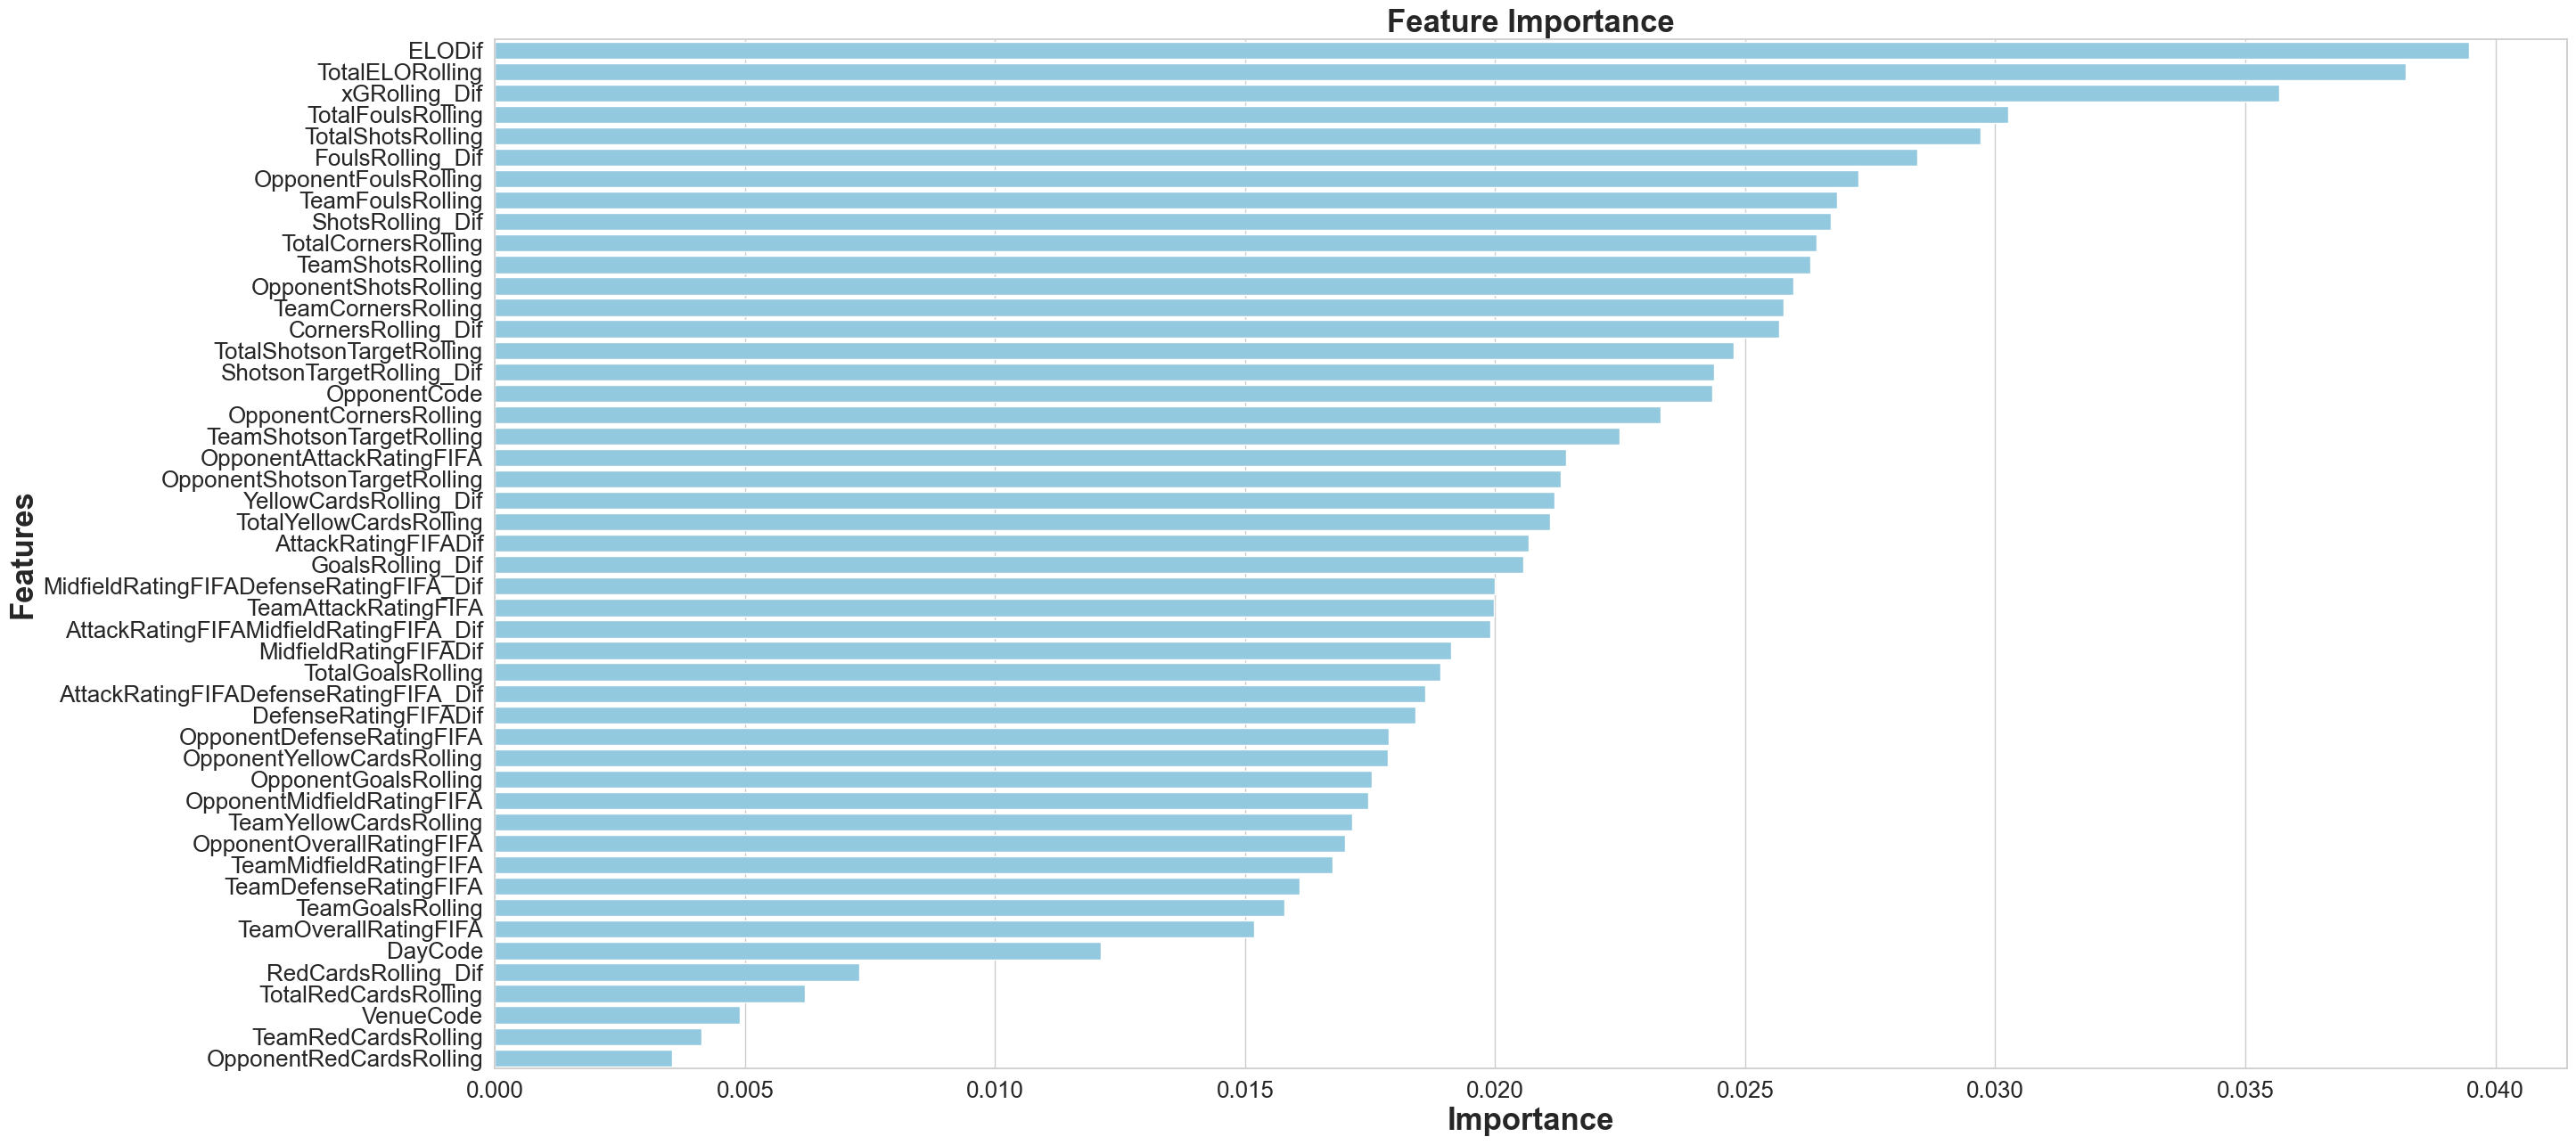

None

,Features,Gini-Importance
0,ELODif,0.039465
1,TotalELORolling,0.038204
2,xGRolling_Dif,0.035668
3,TotalFoulsRolling,0.030253
4,TotalShotsRolling,0.029711
5,FoulsRolling_Dif,0.028436
6,OpponentFoulsRolling,0.027263
7,TeamFoulsRolling,0.026843
8,ShotsRolling_Dif,0.026705
9,TotalCornersRolling,0.026434


In [136]:
#! pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

feats = {}
for feature, importance in zip(X_train.columns, rfc_1.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

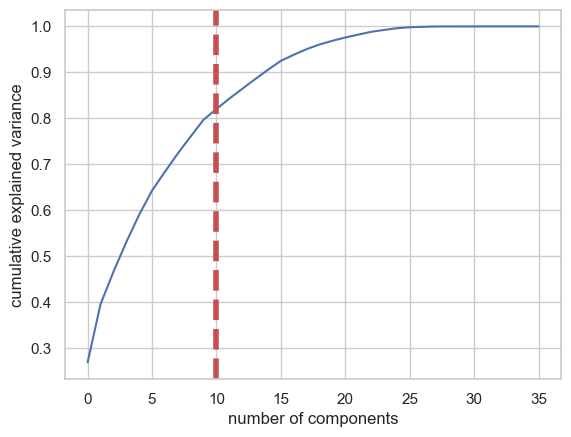

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.268911,0.268911
1,0.395220,0.126308
2,0.465710,0.070490
3,0.530521,0.064811
4,0.590088,0.059567
5,0.642671,0.052583
6,0.683639,0.040968
7,0.723421,0.039781
8,0.760499,0.037079
9,0.796906,0.036407


In [137]:
pca_test = PCA(n_components=36)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [156]:
pca = PCA(n_components=0.85)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [157]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=X_train.columns, index=pca_dims)
pca_test_df.tail(10)

,TotalShotsRolling,TeamGoalsRolling,TeamFoulsRolling,GoalsRolling_Dif,ShotsonTargetRolling_Dif,OpponentShotsonTargetRolling,TotalELORolling,xGRolling_Dif,ShotsRolling_Dif,YellowCardsRolling_Dif,...,AttackRatingFIFAMidfieldRatingFIFA_Dif,MidfieldRatingFIFADefenseRatingFIFA_Dif,TeamOverallRatingFIFA,TeamAttackRatingFIFA,TeamMidfieldRatingFIFA,TeamDefenseRatingFIFA,OpponentOverallRatingFIFA,OpponentAttackRatingFIFA,OpponentMidfieldRatingFIFA,OpponentDefenseRatingFIFA
PCA Component 26,-7.902836e-03,-0.007756,-0.001122,-0.010191,-0.000738,0.002454,-3.167288e-02,7.568329e-03,-0.005384,0.000796,...,0.047113,-0.093707,0.686826,-0.158954,-0.286060,-0.162568,5.155950e-01,-0.126847,-0.252519,-0.183344
PCA Component 27,-3.508586e-03,-0.002626,-0.000936,-0.001282,0.003402,0.005212,-2.167034e-02,-2.940542e-02,0.002610,0.004410,...,0.097090,0.093310,-0.574538,-0.023380,0.094870,0.081549,7.254535e-01,-0.099810,-0.169985,-0.028329
PCA Component 28,-1.452297e-01,0.344705,-0.154604,0.011874,0.014287,0.257744,-1.174182e-03,2.738285e-04,0.000172,0.000615,...,0.000584,0.000130,0.003750,0.000925,-0.000276,-0.001878,2.152883e-03,0.001613,0.000205,-0.000494
PCA Component 29,1.229122e-01,0.237434,0.105202,0.008113,-0.000296,0.005281,-1.370505e-04,1.393652e-03,-0.000466,-0.001345,...,0.000381,0.000944,-0.004207,0.000287,0.001609,-0.000734,2.588203e-03,-0.000242,-0.000231,0.000434
PCA Component 30,1.120403e-01,0.173270,-0.207932,0.005909,-0.000374,-0.015358,3.254511e-04,2.542682e-04,-0.000408,0.001702,...,-0.000933,0.000210,-0.002320,0.000403,0.002127,0.000026,-3.536477e-03,0.000258,0.001839,0.002060
PCA Component 31,-1.746376e-01,-0.051798,-0.133862,-0.002454,0.000607,0.020763,-3.271337e-03,1.392192e-03,0.001091,-0.003218,...,0.000316,0.000332,-0.000956,0.001189,-0.000160,0.000614,6.831608e-04,0.001109,0.000904,-0.000653
PCA Component 32,-2.421907e-01,-0.146067,0.124959,-0.005356,0.019493,0.372360,-4.572152e-04,-4.116496e-04,0.001114,0.000583,...,-0.000655,-0.000628,-0.001989,0.000903,-0.000101,0.000025,-2.716762e-03,0.001572,0.002005,0.000787
PCA Component 33,8.389779e-02,-0.219189,-0.360422,-0.008526,0.004123,0.068751,-3.321346e-04,-7.745350e-04,-0.000459,-0.000401,...,-0.000793,0.000675,0.000973,0.000192,0.000519,-0.000760,-1.919909e-03,0.000818,0.001390,-0.000390
PCA Component 34,4.273706e-01,-0.057784,0.058948,-0.002004,0.014674,0.296630,1.073778e-03,2.168557e-04,-0.002757,-0.000426,...,-0.000299,-0.000442,0.001831,-0.000197,-0.000565,-0.000179,-1.285161e-03,0.000012,0.000213,0.000007
PCA Component 35,4.857226e-17,0.167946,-0.121170,-0.255553,-0.067349,-0.039487,1.179612e-16,1.153591e-16,-0.420541,0.383000,...,0.079668,-0.171764,0.000000,0.052265,0.218515,-0.063000,-1.110223e-16,-0.033584,-0.031273,-0.120274


In [158]:
rfc_2 = RandomForestClassifier(random_state=1)
rfc_2.fit(X_train_scaled_pca, y_train)
#display(rfc.score(X_train_scaled_pca, y_train))
p2 = rfc_2.predict(X_test_scaled_pca)
accuracy_score(p2, y_test)
# 1.0


#xgb_2 = xgb.XGBClassifier(random_state=1)
#xgb_2.fit(X_train_scaled_pca, y_train)
#accuracy_score(xgb_2.predict(X_test_scaled_pca), y_test)

0.5349708576186512

In [141]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc_2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 2, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_
# {'n_estimators': 700,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'log2',
# 'max_depth': 11,
# 'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/runpy.py", line 196, in _run_module_as_main
Traceback (most recent call last):
  File "/Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/r

KeyboardInterrupt: 

In [122]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)


,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,200,39,28,log2,11,True,0.554738,1
1,300,18,18,sqrt,13,True,0.553605,2
2,600,2,34,sqrt,12,True,0.551791,3
3,200,50,28,sqrt,9,True,0.551679,4
4,100,28,34,log2,8,True,0.551112,5
5,600,39,34,log2,13,True,0.550885,6
6,200,12,50,log2,9,True,0.550771,7
7,700,39,34,log2,10,True,0.550658,8
8,400,44,50,log2,10,True,0.550545,9
9,800,18,39,log2,11,True,0.550432,10


[09/30/23 20:34:10] INFO     Using categorical units to plot a list of strings that are all         ]8;id=566143;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=275248;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=538488;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=687332;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=906510;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=381806;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=639626;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=890761;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=10907;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=604859;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=426809;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=595940;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

[09/30/23 20:34:11] INFO     Using categorical units to plot a list of strings that are all         ]8;id=470441;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=556537;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=834022;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=894680;file:///Users/Gautham/miniconda3/envs/dl_hw1/lib/python3.10/site-packages/matplotlib/category.py#234\234]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

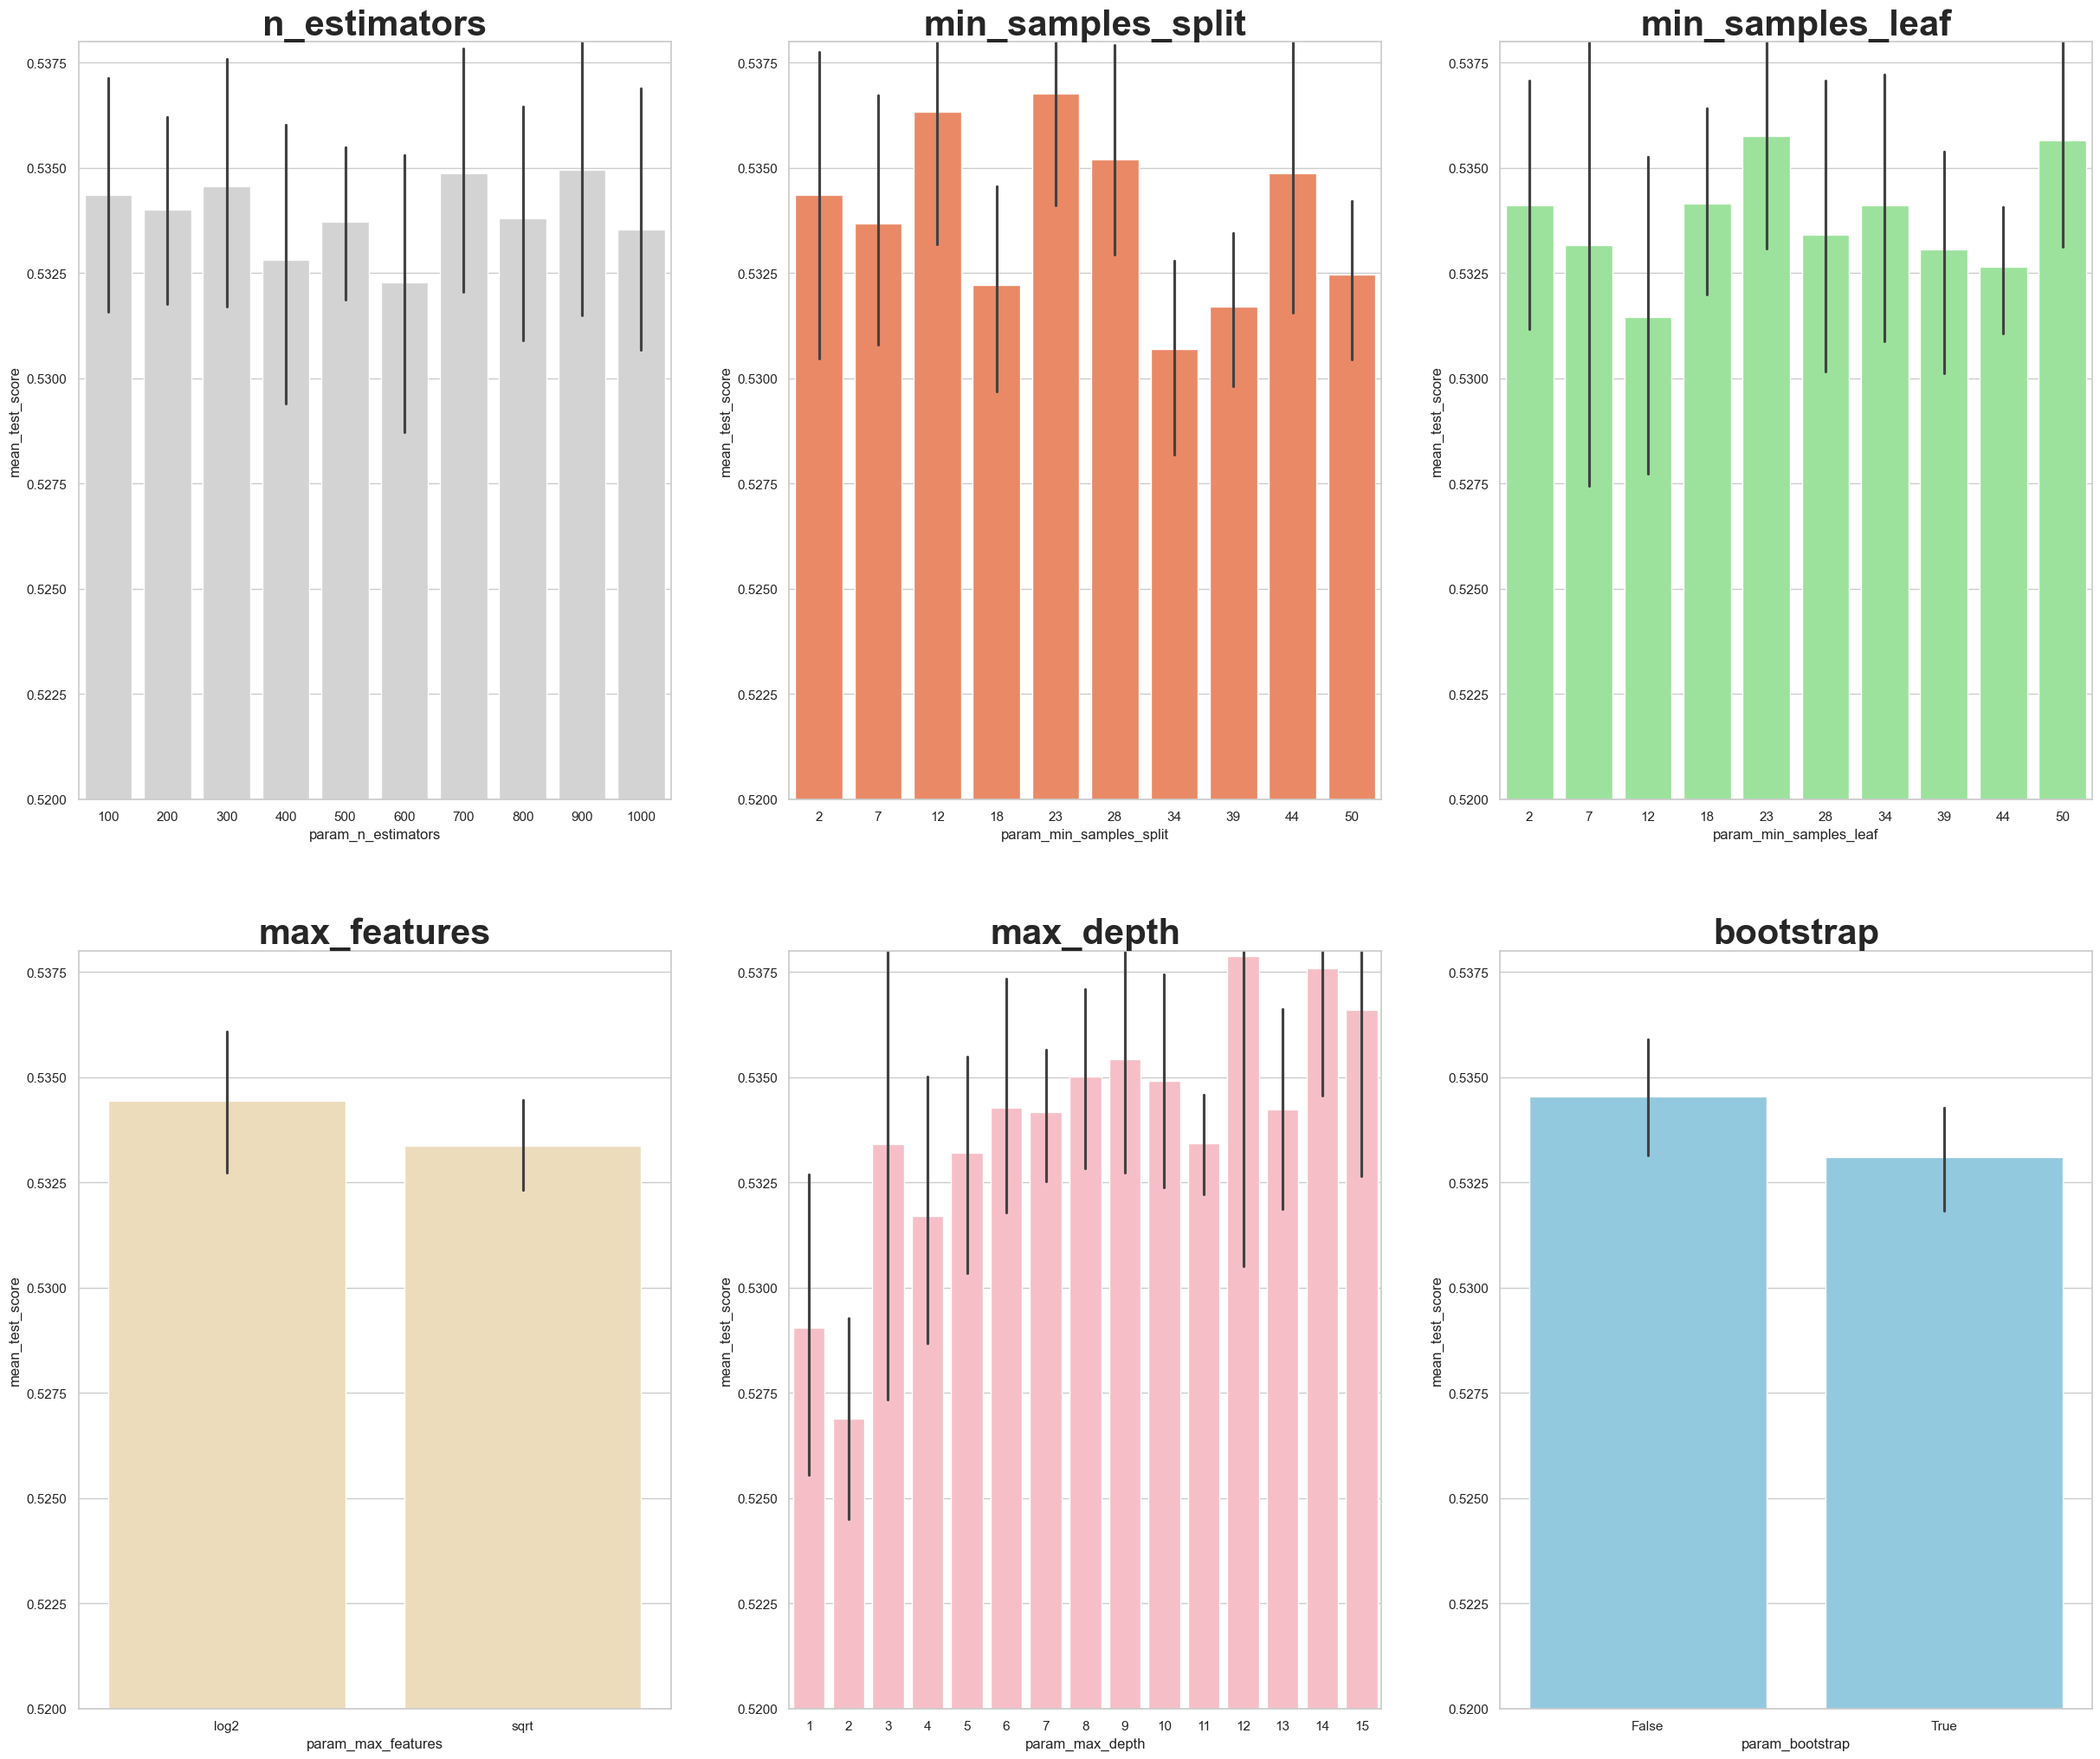

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.52,.538])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.52,.538])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.52,.538])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.52,.538])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.52,.538])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.52,.538])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [70]:
params = {
   
 }
rfc_3 = RandomForestClassifier(n_estimators=100,
 min_samples_split=12,
  min_samples_leaf= 34,
   max_features= 'log2',
 max_depth= 15,
 bootstrap= True,)
rfc_3.fit(X_train_scaled_pca, y_train)
#display(rfc.score(X_train_scaled_pca, y_train))
p3 = rfc_3.predict(X_test_scaled_pca)
accuracy_score(p3, y_test)
# 1.0

0.5216836734693877

In [55]:
from sklearn.model_selection import GridSearchCV
n_estimators = [300,700,900]
max_features = ['log2']
max_depth = [12,14,15]
min_samples_split = [12,23,28]
min_samples_leaf = [23,50]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc_2, param_grid, cv = 3, verbose = 2, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

ap=False, max_depth=12, max_features=log2, min_samples_leaf=23, min_samples_split=23, n_estimators=900; total time=  10.1s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=50, min_samples_split=12, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=50, min_samples_split=12, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=50, min_samples_split=12, n_estimators=300; total time=   3.2s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=23, min_samples_split=28, n_estimators=700; total time=   8.2s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=23, min_samples_split=23, n_estimators=900; total time=  10.4s
[CV] END bootstrap=False, max_depth=12, max_features=log2, min_samples_leaf=23, min_samples_split=23, n_estimators=900; total time=  10.5s
[CV] END bootstrap=False, max_depth=12, max

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 23,
 'min_samples_split': 28,
 'n_estimators': 300}

In [57]:
#display(rfc.score(X_train_scaled_pca, y_train))
p3 = rfc_3.predict(X_test_scaled_pca)
accuracy_score(p3, y_test)

0.5232142857142857

In [45]:
params = {'bootstrap': False,
 'max_depth': 14,
 'max_features': 'log2',
 'min_samples_leaf': 23,
 'min_samples_split': 12,
 'n_estimators': 300}
rfc_4 = RandomForestClassifier(params)
rfc_4.fit(X_train_scaled_pca, y_train)
#display(rfc.score(X_train_scaled_pca, y_train))
p4 = rfc_4.predict(X_test_scaled_pca)
accuracy_score(p4, y_test)
# 1.0

0.525765306122449

In [453]:
def xgb_model(X_train, y_train, X_test, y_test):
    params = {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'reg_lambda': 0, 'subsample': 0.8}
    clf = xgb.XGBClassifier(**params)
    '''verbosity=0,
                           learning_rate=0.01,
                           colsample_bytree=0.7,
                           subsample=0.7,
                           objective='binary:logistic',
                           n_estimators=200,
                           max_depth=3,
                           gamma=0.1,
                           seed=1,
                           eta=0.2,
                           min_child_weight=2)
    '''
    #clf = RandomForestClassifier(n_estimators=50, min_samples_split=7, random_state=1) 
    clf.fit(X_train, y_train)
    # Accuracy
    ypred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, ypred)
    return clf, accuracy

def print_feature_importances(clf, cols, print_num):
   feats = {}  # a dict to hold feature_name: feature_importance
   for feature, importance in zip(cols, clf.feature_importances_):
       feats[feature] = importance
   q = [[k, v] for k, v in sorted(feats.items(), key=lambda item: item[1])]
   for x in q[-print_num:]:
       print(x[0], x[1])

print_num = 30
cols = X_train.columns
clf, accuracy = xgb_model(X_train, y_train, X_test, y_test)
print_feature_importances(clf, cols, print_num)
print(accuracy)

TotalYellowCardsRolling 0.024924261
ShotsonTargetRolling_Dif 0.02499685
VenueCode 0.025154328
GoalsRolling_Dif 0.025623787
YellowCardsRolling_Dif 0.025818273
OpponentYellowCardsRolling 0.026125325
OpponentCornersRolling 0.026170049
OpponentShotsonTargetRolling 0.026490774
OpponentShotsRolling 0.026593573
TotalCornersRolling 0.026896594
OpponentRedCardsRolling 0.026978254
TeamYellowCardsRolling 0.027125483
TotalFoulsRolling 0.027273849
OpponentFoulsRolling 0.02758492
FoulsRolling_Dif 0.027921027
xGRolling_Dif 0.028060777
OpponentGoalsRolling 0.02869751
TeamShotsRolling 0.028739775
CornersRolling_Dif 0.028942412
TeamFoulsRolling 0.02976636
ShotsRolling_Dif 0.029855309
TeamCornersRolling 0.030276125
TotalShotsRolling 0.03038683
TotalShotsonTargetRolling 0.030493107
RedCardsRolling_Dif 0.030614188
TeamShotsonTargetRolling 0.03178011
DayCode 0.03284824
OpponentCode 0.035022225
TotalELORolling 0.03989633
ELODif 0.07962738
0.5303571428571429


In [417]:
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel


def threshold_selector(clf, X_train, y_train, X_test, y_test):
   thresholds = np.arange(.1, 5, .05)
   avgs = []
   loopavg = []
   count = 1

   for thresh in thresholds:
       # Run each threshold 10x for the avg
       for x in range(0, 10):
           selection = SelectFromModel(clf, threshold=f'{thresh}*median', prefit=True)
           select_X_train = selection.transform(X_train)
           model = xgb.XGBClassifier(verbosity=0,
                                reg_lambda=0.023385762997113632,
                                reg_alpha=0.003694895205081855,
                                #tree_method="gpu_hist",
                                objective="binary:logistic",
                                n_jobs=-1,
                                learning_rate=0.0059107879099318415,
                                min_child_weight=15,
                                max_depth=1,
                                max_delta_step=10,
                                subsample=0.5370056644955932,
                                colsample_bytree=0.5742787613391558,
                                gamma=0.09815563994539223,
                                n_estimators=143,
                                eta=0.1134711359195081,
                                seed=1)
           count +=1
           model.fit(select_X_train, y_train.values.ravel())
           select_X_test = selection.transform(X_test)
           ypred = model.predict(select_X_test)
           accuracy = accuracy_score(y_test, ypred)
           msg = f"Thresh={thresh}, n={select_X_train.shape[1]}, Accuracy: {accuracy * 100.0}"
           print(msg)
           loopavg.append(accuracy)

       avgs.append((thresh, np.mean(loopavg)))
       loopavg = []

   for x in avgs:
       print(x)

threshold_selector(clf, X_train, y_train, X_test, y_test)

Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.1, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 54.61805555555556
Thresh=0.15000000000000002, n=35, Accuracy: 

XGBoostError: [22:17:52] /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:202: Check failed: n_features >= 1 (0 vs. 1) : Data must has at least 1 column.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000011dfd4ab5 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x000000011e0e74ff xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 8431
  [bt] (2) 3   libxgboost.dylib                    0x000000011e0e4d0c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (3) 4   libxgboost.dylib                    0x000000011e099579 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (4) 5   libxgboost.dylib                    0x000000011dfdfbae XGQuantileDMatrixCreateFromCallback + 590
  [bt] (5) 6   libffi.8.dylib                      0x0000000104f33a22 ffi_call_unix64 + 82



In [268]:

print('predicting')
#predictors = ['VenueCode', 'OpponentCode', 'ELODif']
#ew_df = df_rolling.dropna(subset=['O2.5'])
#train = new_df[new_df['Date'] < '2023-08']
#test = new_df[new_df['Date'] >= '2023-08']
#combined, precision, accuracy = func.make_predictions(df_rolling, predictors+new_cols, train, test)
#precision, accuracy, combined
date = str(d.today())#'2023-09-26'

dif_cols = func.prep_data(df_rolling, date)#['30/09/23', '01/10/23', '02/10/23'])
predictors = ['VenueCode', 'OpponentCode', 'ELODif', 'Day'] + dif_cols
targets = ['WinLoseTarget', 'OU1.5Target', 'OU2.5Target', 
'OU3.5Target', 'WinTarget', 'DrawTarget', 'LossTarget']
#targets = ['WinLoseTarget', 'Target', 'WinTarget', 'DrawTarget', 'LossTarget']

for target in targets:
    #print(target)
    if train:
        combined = func.train(date, target, predictors)
        preds, c = func.predict(predictors)
    else:
        preds, c = func.predict(predictors)
    c['preds'] = preds
    table = c.sort_index()[['GameID','Date','Team', 'Opponent', 'preds']].merge(c[['GameID','Date','Team', 'Opponent', 'preds']], left_on=['Date', 'Team'], right_on=['Date', 'Opponent']).drop_duplicates(['GameID_x'])
    table.to_csv(f'Predictions/{league}/{league}_{target}.csv')
'''

SyntaxError: incomplete input (1514939339.py, line 26)